In [44]:
import sys
from itertools import product

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from IPython.display import clear_output

# Contains previous code for calculating pressure from lnsp.
from mcs_prime.era5_calc import ERA5Calc

sys.path.insert(0, '/home/users/mmuetz/projects/ecape_calc')
from ecape_calc import compute_CAPE_CIN, compute_NCAPE, compute_VSR, compute_ETILDE
from params import T1, T2

In [46]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [1]:
ds = xr.load_dataset('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_env_cond_reviews/ecape/2020/01/01/ecmwf-era5_oper_an_ml_202001010000.ecape.nc')

NameError: name 'xr' is not defined

In [6]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 481, level: 137)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... -59.5 -59.75 -60.0
    time       datetime64[ns] 2020-01-01
  * level      (level) int32 1 2 3 4 5 6 7 8 ... 130 131 132 133 134 135 136 137
Data variables:
    lnsp       (latitude, longitude) float32 11.53 11.53 11.53 ... 11.49 11.49
    q          (level, latitude, longitude) float32 1.697e-06 ... 0.002732
    t          (level, latitude, longitude) float32 213.7 214.0 ... 271.8 271.8
    u          (level, latitude, longitude) float32 54.83 53.61 ... -6.256
    v          (level, latitude, longitude) float32 26.96 25.83 ... 2.979 2.944
    z          (latitude, longitude) float32 2.34 5.023 -9.281 ... -1.234 -3.918
Attributes:
    Conventions:  CF-1.6
    history:      2020-04-06 11:19:13 GMT by grib_to_netcdf-2.14.0: grib_to_n...

In [7]:
Rd = 287.06
g = 9.80665
# As used by IFS: https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-SpatialreferencesystemsandEarthmodel
Re = 6371229 # m

In [8]:
class Era5ComputeAlt:
    """Compute geopotential (z) from netcdf data, then compute altitude (alt)
    
    Code taken from existing code for doing the same for GRIB data"""
    def __init__(self, ds):
        self.ds = ds
        self.e5calc = ERA5Calc('/gws/nopw/j04/mcs_prime/mmuetz/data/ERA5/ERA5_L137_model_levels_table.csv')


    def run(self):
        T = self.ds.t.values
        q = self.ds.q.values
        p = self.e5calc.calc_pressure(self.ds.lnsp.values)
        self.p = p
        zsfc = self.ds.z.values
        
        # Get levels in ascending order of height (starts at 137)
        levels = self.ds.level.values[::-1]
        # print(levels)

        # 0.609133 = Rv/Rd - 1.
        # TODO: Why extra RD
        Tv = T * (1. + 0.609133 * q) * Rd
        z_h = zsfc

        z = np.zeros_like(p)
        for lev in levels:
            lev_idx = lev - 1
            # print(lev, lev_idx)
            z_h, z_f = self.compute_z_level(lev_idx, p, Tv, z_h)
            z[lev_idx] = z_f

        h = z / g
        alt = Re * h / (Re - h)

        self.z = z
        self.h = h
        self.alt = alt
        return z, h, alt

    def compute_z_level(self, lev_idx, p, Tv, z_h):
        '''Compute z at half & full level for the given level, based on T/q/sp'''
        # compute the pressures (on half-levels)
        # ph_lev, ph_levplusone = get_ph_levs(values, lev)
        ph_lev, ph_levplusone = p[lev_idx - 1], p[lev_idx]
    
        if lev_idx == 0:
            dlog_p = np.log(ph_levplusone / 0.1)
            alpha = np.log(2)
        else:
            dlog_p = np.log(ph_levplusone / ph_lev)
            alpha = 1. - ((ph_lev / (ph_levplusone - ph_lev)) * dlog_p)
    
        # z_f is the geopotential of this full level
        # integrate from previous (lower) half-level z_h to the
        # full level
        z_f = z_h + (Tv[lev_idx] * alpha)
    
        # z_h is the geopotential of 'half-levels'
        # integrate z_h to next half level
        z_h = z_h + (Tv[lev_idx] * dlog_p)
    
        return z_h, z_f

In [9]:
comp_alt = Era5ComputeAlt(ds)
_ = comp_alt.run()

In [14]:
def compute_ECAPE_etc(ds, comp_alt, lon_idx, lat_idx):
    # ERA5 indexes levels from highest to lowest.
    levlatlon_idx = (slice(None, None, -1), lat_idx, lon_idx)
    T0 = ds.t.values[levlatlon_idx]
    q0 = ds.q.values[levlatlon_idx]
    u0 = ds.u.values[levlatlon_idx]
    v0 = ds.v.values[levlatlon_idx]
    p0 = comp_alt.p[levlatlon_idx]
    z0 = comp_alt.alt[levlatlon_idx]

    CAPE, CIN, LFC, EL = compute_CAPE_CIN(T0, p0, q0, 0, 0, 0, z0, T1, T2)
    
    if not (np.isnan(LFC) or np.isnan(EL)):
        NCAPE, MSE0_star, MSE0bar = compute_NCAPE(T0, p0, q0, z0, T1, T2, LFC, EL)
        
        # Get the 0-1 km mean storm-relative wind, estimated using bunkers2000 method for right-mover storm motion
        V_SR, C_x, C_y = compute_VSR(z0, u0, v0)
        
        # Get e_tilde, which is the ratio of ecape to cape.  also, varepsilon is the fracitonal entrainment rate, and radius is the theoretical upraft radius
        Etilde, varepsilon, radius = compute_ETILDE(CAPE, NCAPE, V_SR, EL, 120)
        ECAPE = CAPE * Etilde
    
        return dict(
            CAPE=CAPE,
            CIN=CIN,
            LFC=LFC,
            EL=EL,
            NCAPE=NCAPE,
            V_SR=V_SR,
            Etilde=Etilde,
            varepsilon=varepsilon,
            radius=radius,
            ECAPE=Etilde * CAPE,
        )
    else:
        return None

In [15]:
%%timeit
compute_ECAPE_etc(ds, comp_alt, 0, 240)

12.8 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
print(f'Time to run over full domain: {481 * 1440 * 0.0128 / 3600:.3f}h')
print(f'Time to run over 1/100 domain: {0.01 * 481 * 1440 * 0.0128 / 60:.3f}m')

Time to run over full domain: 2.463h
Time to run over 1/100 domain: 1.478m


In [98]:
lons = list(range(0, 1440, 4))
lats = list(range(0, 481, 4))
output = np.full((10, len(lats), len(lons)), np.nan)
for i, lon_idx in enumerate(lons):
    print(f'{i / len(lons) * 100}%')
    for j, lat_idx in enumerate(lats):
        # print(lon_idx, lat_idx)
        try:
            ecape_dict = compute_ECAPE_etc(ds, comp_alt, lon_idx, lat_idx)
            for k, key in enumerate(ecape_dict.keys()):
                output[k, j, i] = ecape_dict[key]
        except Exception as e:
            # output[(lon_idx, lat_idx)] = e
            pass


0.0%
0.2777777777777778%


/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/users/mmuetz/projects/ecape_calc/ecape_calc.py:471: RuntimeWarning: Mean of empty slice
  V_SR = np.nanmean(np.sqrt(u_sr[f1000] ** 2 + v_sr[f1000] ** 2))


0.5555555555555556%


/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.8333333333333334%
1.1111111111111112%
1.3888888888888888%
1.6666666666666667%
1.9444444444444444%
2.2222222222222223%
2.5%
2.7777777777777777%
3.0555555555555554%
3.3333333333333335%
3.6111111111111107%
3.888888888888889%
4.166666666666666%
4.444444444444445%
4.722222222222222%
5.0%
5.277777777777778%
5.555555555555555%
5.833333333333333%
6.111111111111111%
6.388888888888888%
6.666666666666667%
6.944444444444445%
7.222222222222221%
7.5%
7.777777777777778%
8.055555555555555%
8.333333333333332%
8.61111111111111%
8.88888888888889%
9.166666666666666%
9.444444444444445%
9.722222222222223%
10.0%
10.277777777777777%
10.555555555555555%
10.833333333333334%
11.11111111111111%
11.38888888888889%
11.666666666666666%
11.944444444444445%
12.222222222222221%
12.5%
12.777777777777777%
13.055555555555557%
13.333333333333334%
13.61111111111111%
13.88888888888889%
14.166666666666666%
14.444444444444443%
14.722222222222223%
15.0%
15.277777777777779%
15.555555555555555%
15.833333333333332%
16.1111111111

In [99]:
lon = ds.longitude.values[lons]
lat = ds.latitude.values[lats]

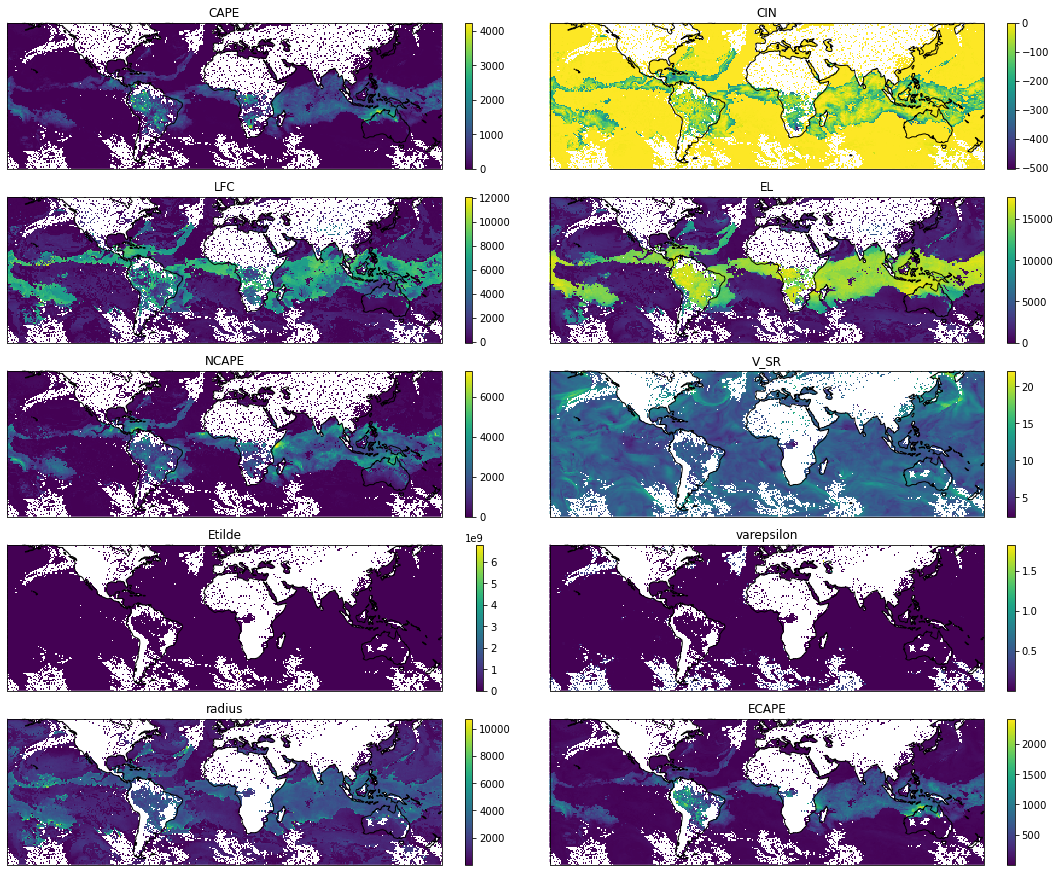

In [100]:
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, layout='constrained', subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 12)
for i, (key, ax) in enumerate(zip(ecape_dict.keys(), axes.flatten())):
    ax.set_title(key)
    im = ax.pcolormesh(lon, lat, output[i])
    plt.colorbar(im, ax=ax)
    ax.coastlines()

In [101]:
nanmask = ~np.isnan(output[-1])

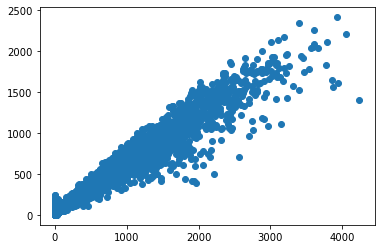

In [102]:
plt.scatter(output[0][nanmask], output[9][nanmask])

In [103]:
import pandas as pd
import seaborn as sns

In [104]:
o2 = []
for i in range(10):
    o2.append(output[i][nanmask])
o2 = np.array(o2)

In [105]:
df = pd.DataFrame(o2.T, columns=ecape_dict.keys())

In [61]:
df

,CAPE,CIN,LFC,EL,NCAPE,V_SR,Etilde,varepsilon,radius,ECAPE
0,9.975461e-02,-0.000008,21.277452,157.426093,7.995858,9.268967,4.044120e+02,0.006409,142.199263,40.341963
1,1.567826e+01,-0.387342,394.660900,1197.903857,0.000000,12.407039,5.831796e+00,0.000140,962.072386,91.432448
2,8.543784e-07,0.000000,286.337464,296.706759,0.000000,16.411493,1.576217e+08,0.001921,259.722906,134.668557
3,1.588960e-02,-0.000010,24.237033,70.328501,0.000000,10.239490,3.299693e+03,0.034201,61.557972,52.430787
4,3.145027e+00,-0.000005,22.033024,412.952166,19.529901,10.949948,1.884799e+01,0.000981,363.525596,59.277420
...,...,...,...,...,...,...,...,...,...,...
5266,8.217068e+00,0.000000,10.063534,823.253894,5.605056,8.259727,4.967178e+00,0.000299,658.800567,40.815643
5267,3.533427e+00,0.000000,10.057004,913.325359,14.723016,8.241551,1.015125e+01,0.000214,777.937236,35.868689
5268,4.830265e-01,-1.543215,587.961466,737.484051,1.016851,8.074171,6.816077e+01,0.000314,642.341063,32.923457
5269,7.071431e-01,-3.894078,1113.918735,1226.840265,0.000000,8.365465,5.041588e+01,0.000114,1063.919122,35.651241


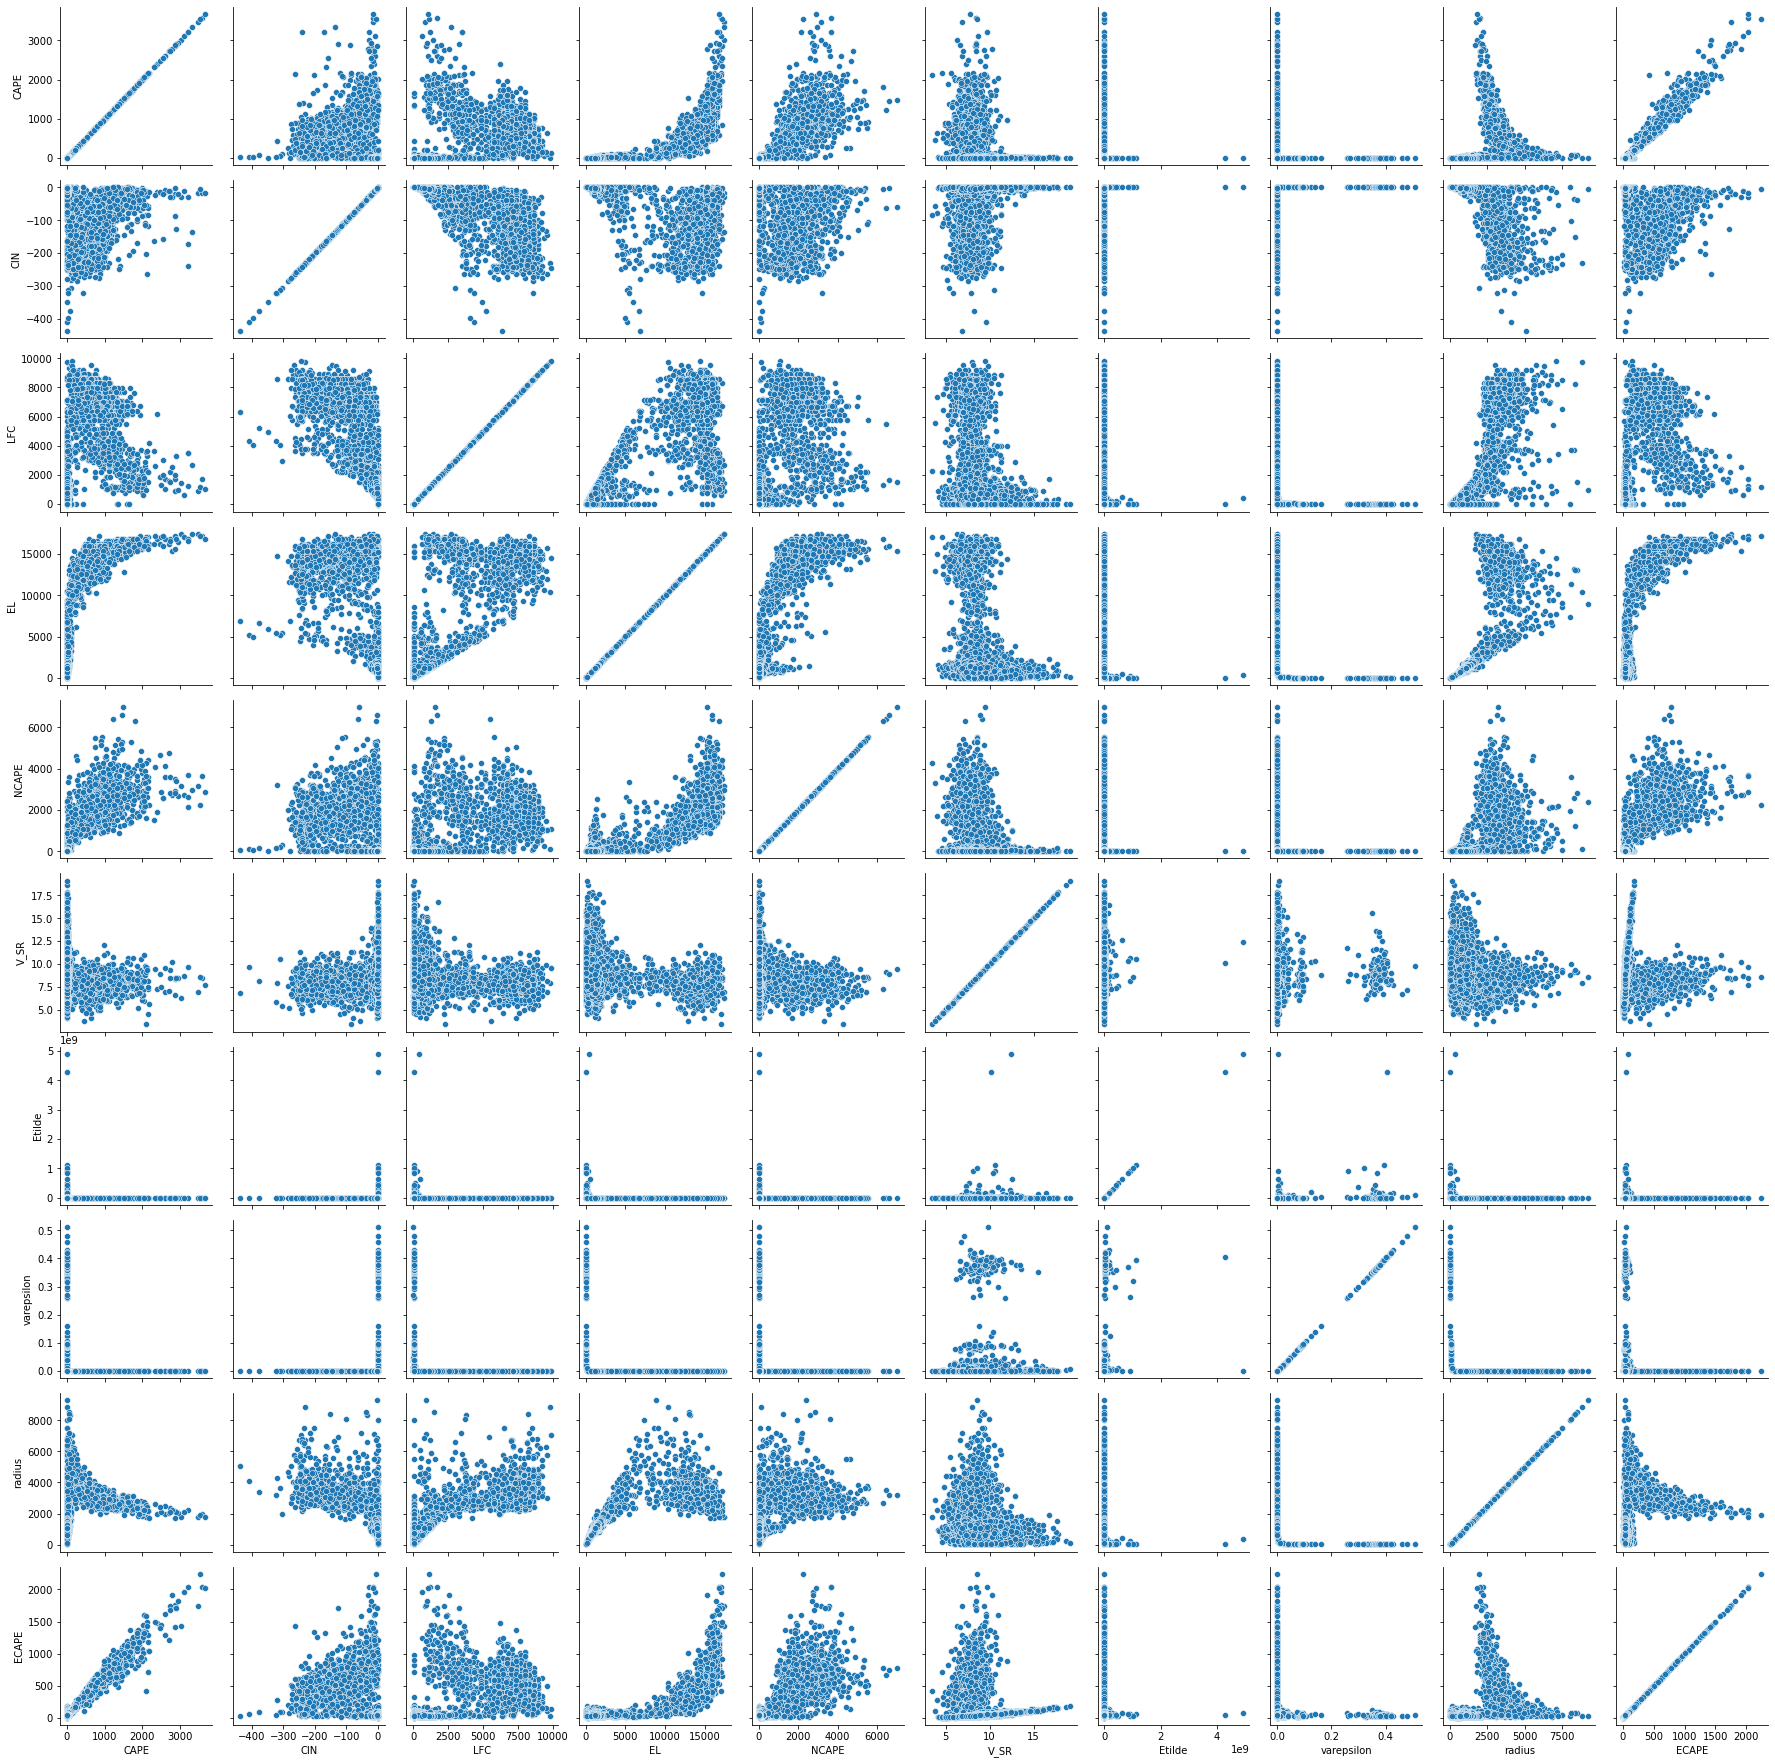

In [62]:
g = sns.PairGrid(df)
g.map(sns.scatterplot)

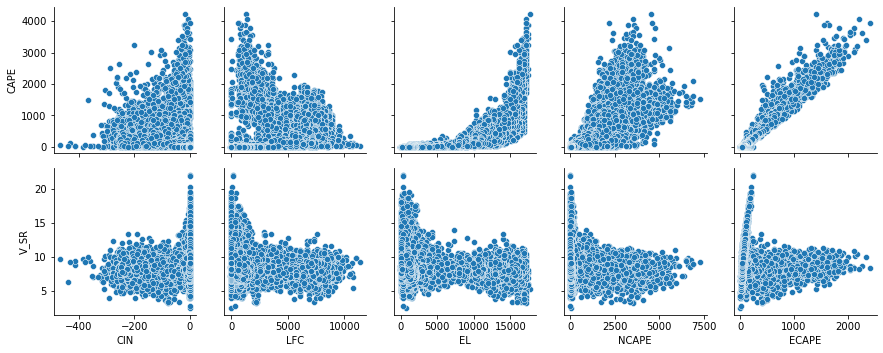

In [106]:
g = sns.PairGrid(df, x_vars=['CIN', 'LFC', 'EL', 'NCAPE', 'ECAPE'], y_vars=['CAPE', 'V_SR'])
g.map(sns.scatterplot)



In [107]:
from scipy.stats import linregress
from matplotlib.colors import LogNorm

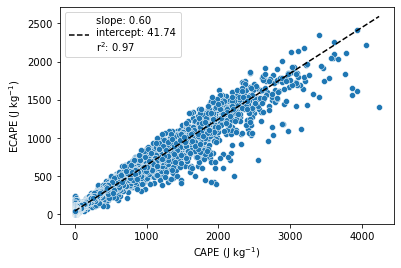

In [108]:
lr = linregress(df.CAPE, df.ECAPE)
sns.scatterplot(df, x='CAPE', y='ECAPE')
# sns.jointplot(x=df.CAPE, y=df.ECAPE, kind="hex", norm=LogNorm())
x = np.array([df.CAPE.min(), df.CAPE.max()])
y = lr.slope * x + lr.intercept
plt.plot(x, y, 'k--', label=f'slope: {lr.slope:.2f}\nintercept: {lr.intercept:.2f}\nr$^2$: {lr.rvalue**2:.2f}')
plt.xlabel('CAPE (J kg$^{-1}$)')
plt.ylabel('ECAPE (J kg$^{-1}$)')
plt.legend()


In [110]:
output.shape

(10, 121, 360)

In [45]:
basedir = '/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_env_cond_reviews/ecape/2020/??/01/quick/'
ds = xr.open_mfdataset(basedir + 'ecmwf-era5_oper_an_ml_2020??01????.ecape.quick.nc')
ds.time

<xarray.DataArray 'time' (time: 236)>
array(['2020-01-01T00:00:00.000000000', '2020-01-01T01:00:00.000000000',
       '2020-01-01T02:00:00.000000000', ..., '2020-12-01T21:00:00.000000000',
       '2020-12-01T22:00:00.000000000', '2020-12-01T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-12-01T23:00:00

In [41]:
ds.load()

<xarray.Dataset>
Dimensions:     (time: 236, latitude: 49, longitude: 144)
Coordinates:
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-12-01T23:00:00
  * latitude    (latitude) float32 60.0 57.5 55.0 52.5 ... -55.0 -57.5 -60.0
  * longitude   (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    CAPE        (time, latitude, longitude) float64 0.09975 nan ... 4.299
    CIN         (time, latitude, longitude) float64 -8.342e-06 nan ... -17.1
    LFC         (time, latitude, longitude) float64 21.28 nan ... 917.3
    EL          (time, latitude, longitude) float64 157.4 nan ... 1.357e+03
    NCAPE       (time, latitude, longitude) float64 7.996 nan 0.0 ... 0.0 0.6674
    V_SR        (time, latitude, longitude) float64 9.269 nan ... 8.849 8.176
    Etilde      (time, latitude, longitude) float64 404.4 nan ... 8.699
    varepsilon  (time, latitude, longitude) float64 0.006409 nan ... 0.0001028
    radius      (time, latitude, longitude) float64 142.2 nan ... 1.123e+03
    ECAPE       (time, latitude, longitude) float64 40.34 nan ... 39.19 37.4
Attributes: (12/35)
    ECAPE param L_m:            120
    ECAPE param RA_filter_fac:  0.9
    ECAPE param T1:             273.15
    ECAPE param T2:             253.15
    ECAPE param alpha:          0.8
    ECAPE param sigma:          1.1
    ...                         ...
    task doc:                   None
    created on:                 2024-07-12 17:01:36.563979
    nodename:                   sci4.jasmin.ac.uk
    hostname:                   jasmin
    output path:                /gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime...
    contact:                    mark.muetzelfeldt@reading.ac.uk

In [47]:
time = pd.DatetimeIndex(ds.time)

In [51]:
from collections import Counter
Counter(time.month.values)

Counter({1: 24,
         2: 18,
         3: 22,
         4: 24,
         5: 24,
         6: 24,
         7: 8,
         8: 18,
         9: 7,
         10: 22,
         11: 22,
         12: 23})

In [42]:
dkeys = list(ds.data_vars.keys())

/tmp/ipykernel_5334/3802800706.py:5: RuntimeWarning: Mean of empty slice
  im = ax.pcolormesh(ds.longitude, ds.latitude, np.nanmean(ds[key].values, axis=0))
/tmp/ipykernel_5334/3802800706.py:5: RuntimeWarning: Mean of empty slice
  im = ax.pcolormesh(ds.longitude, ds.latitude, np.nanmean(ds[key].values, axis=0))
/tmp/ipykernel_5334/3802800706.py:5: RuntimeWarning: Mean of empty slice
  im = ax.pcolormesh(ds.longitude, ds.latitude, np.nanmean(ds[key].values, axis=0))
/tmp/ipykernel_5334/3802800706.py:5: RuntimeWarning: Mean of empty slice
  im = ax.pcolormesh(ds.longitude, ds.latitude, np.nanmean(ds[key].values, axis=0))
/tmp/ipykernel_5334/3802800706.py:5: RuntimeWarning: Mean of empty slice
  im = ax.pcolormesh(ds.longitude, ds.latitude, np.nanmean(ds[key].values, axis=0))


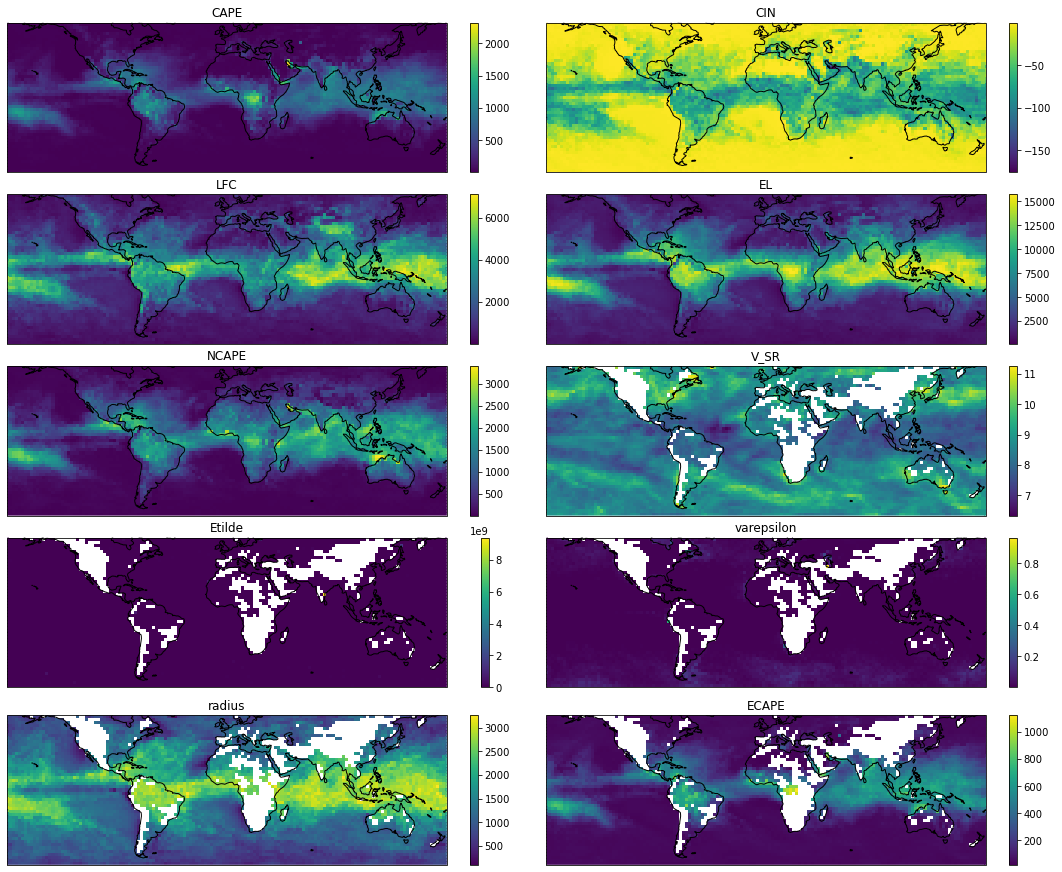

In [43]:
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, layout='constrained', subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(15, 12)
for i, (key, ax) in enumerate(zip(dkeys, axes.flatten())):
    ax.set_title(key)
    im = ax.pcolormesh(ds.longitude, ds.latitude, np.nanmean(ds[key].values, axis=0))
    plt.colorbar(im, ax=ax)
    ax.coastlines()

In [35]:

from scipy.stats import linregress
import seaborn as sns
from matplotlib.colors import LogNorm

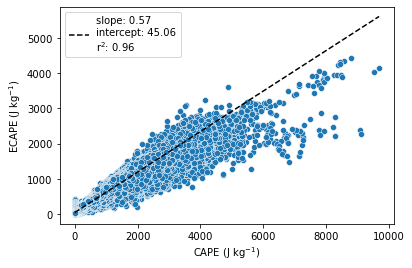

In [44]:
cape = ds.CAPE.values.flatten()
ecape = ds.ECAPE.values.flatten()
cape = cape[~np.isnan(ecape)]
ecape = ecape[~np.isnan(ecape)]

lr = linregress(cape, ecape)
sns.scatterplot(x=cape, y=ecape)
# sns.jointplot(x=df.CAPE, y=df.ECAPE, kind="hex", norm=LogNorm())
x = np.array([cape.min(), cape.max()])
y = lr.slope * x + lr.intercept
plt.plot(x, y, 'k--', label=f'slope: {lr.slope:.2f}\nintercept: {lr.intercept:.2f}\nr$^2$: {lr.rvalue**2:.2f}')
plt.xlabel('CAPE (J kg$^{-1}$)')
plt.ylabel('ECAPE (J kg$^{-1}$)')
plt.legend()
